# Deep learning meets missing data: Doing it MIWAE


In this notebook, we'll show how to learn a deep generative model on a small and **incomplete** continuous data set. We will also show how to **impute** the missing values of this data set. 

This is based on the following paper, available [on arXiv](https://arxiv.org/abs/1812.02633):

P.-A. Mattei & J. Frellsen, **MIWAE: Deep Generative Modelling and Imputation of Incomplete Data Sets**, *International Conference on Machine Learning*, in press (2019)


# Installing and loading useful stuff

In [1]:
!pip3 install --user --upgrade scikit-learn # We need to update it to run missForest
import tensorflow as tf
import numpy as np
import scipy.stats
import scipy.io
import scipy.sparse
from scipy.io import loadmat
import pandas as pd
import tensorflow_probability as tfp
tfd = tfp.distributions
tfk = tf.keras
tfkl = tf.keras.layers
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn import preprocessing
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import BayesianRidge
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer


Requirement already up-to-date: scikit-learn in /root/.local/lib/python3.6/site-packages (0.21.2)

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
def mse(xhat,xtrue,mask): # MSE function for imputations
    xhat = np.array(xhat)
    xtrue = np.array(xtrue)
    return np.mean(np.power(xhat-xtrue,2)[~mask])

# Loading the data



> We'll use the breast cancer data set from scikit-learn.



In [0]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer(True)[0]

It is also possible to use the "white wine" or "red wine" UCI data sets by uncommenting one of the following cells.

In [0]:
#url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
#data = np.array(pd.read_csv(url, low_memory=False, sep=';'))

In [0]:
#url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
#data = np.array(pd.read_csv(url, low_memory=False, sep=';'))

We now standardise the data:

In [0]:
xfull = (data - np.mean(data,0))/np.std(data,0)


n = xfull.shape[0]
p = xfull.shape[1]

We will remove uniformy at random 50% of the data.

In [0]:
np.random.seed(1234)
tf.set_random_seed(1234)

perc_miss = 0.5 # 50% of missing data
xmiss = np.copy(xfull)
xmiss_flat = xmiss.flatten()
miss_pattern = np.random.choice(n*p, np.floor(n*p*perc_miss).astype(np.int), replace=False)
xmiss_flat[miss_pattern] = np.nan 
xmiss = xmiss_flat.reshape([n,p]) # in xmiss, the missing values are represented by nans
mask = np.isfinite(xmiss) # binary mask that indicates which values are missing

A simple way of imputing the incomplete data is to replace the missing values by zeros. This x_hat0 is what will be fed to our encoder.

In [0]:
xhat_0 = np.copy(xmiss)
xhat_0[np.isnan(xmiss)] = 0

# Placeholders and hyperparemeters

In [0]:
x = tf.placeholder(tf.float32, shape=[None, p]) # Placeholder for xhat_0
learning_rate = tf.placeholder(tf.float32, shape=[])
batch_size = tf.shape(x)[0]
xmask = tf.placeholder(tf.bool, shape=[None, p])
K= tf.placeholder(tf.int32, shape=[]) # Placeholder for the number of importance weights


In [0]:
h = 128 # number of hidden units in (same for all MLPs)
d = 10 # dimension of the latent space

# Model building

In [0]:
p_z = tfd.MultivariateNormalDiag(loc=tf.zeros(d, tf.float32))

In [0]:
decoder = tfk.Sequential([
  tfkl.InputLayer(input_shape=[d,]),
  tfkl.Dense(h, activation='tanh',kernel_initializer="orthogonal"),
  tfkl.Dense(h, activation='tanh',kernel_initializer="orthogonal"),
  tfkl.Dense(3*p,kernel_initializer="orthogonal")
])

#Building the inference network (*aka* encoder)

In [0]:
tiledmask = tf.tile(xmask,[K,1])
tiledmask_float = tf.cast(tiledmask,tf.float32)
mask_not_float = tf.abs(-tf.cast(xmask,tf.float32))

iota = tf.Variable(np.zeros([1,p]),dtype=tf.float32)
tilediota = tf.tile(iota,[batch_size,1])
iotax = x + tf.multiply(tilediota,mask_not_float)

In [0]:
encoder = tfk.Sequential([
  tfkl.InputLayer(input_shape=[p,]),
  tfkl.Dense(h, activation='tanh',kernel_initializer="orthogonal"),
  tfkl.Dense(h, activation='tanh',kernel_initializer="orthogonal"),
  tfkl.Dense(3*d,kernel_initializer="orthogonal")
])

#Building the MIWAE loss

In [0]:
out_encoder = encoder(iotax)
q_zgivenxobs = tfd.Independent(distribution=tfd.StudentT(loc=out_encoder[..., :d], scale=tf.nn.softplus(out_encoder[..., d:(2*d)]), df=3 + tf.nn.softplus(out_encoder[..., (2*d):(3*d)])))
zgivenx = q_zgivenxobs.sample(K)
zgivenx_flat = tf.reshape(zgivenx,[K*batch_size,d])
data_flat = tf.reshape(tf.tile(x,[K,1]),[-1,1])

In [0]:
out_decoder = decoder(zgivenx_flat)
all_means_obs_model = out_decoder[..., :p]
all_scales_obs_model = tf.nn.softplus(out_decoder[..., p:(2*p)]) + 0.0001
all_degfreedom_obs_model = tf.nn.softplus(out_decoder[..., (2*p):(3*p)]) + 3
all_log_pxgivenz_flat = tfd.StudentT(loc=tf.reshape(all_means_obs_model,[-1,1]),scale=tf.reshape(all_scales_obs_model,[-1,1]),df=tf.reshape(all_degfreedom_obs_model,[-1,1])).log_prob(data_flat)
all_log_pxgivenz = tf.reshape(all_log_pxgivenz_flat,[K*batch_size,p])

In [0]:
logpxobsgivenz = tf.reshape(tf.reduce_sum(tf.multiply(all_log_pxgivenz,tiledmask_float),1),[K,batch_size])
logpz = p_z.log_prob(zgivenx)
logq = q_zgivenxobs.log_prob(zgivenx)

In [0]:
miwae_loss = -tf.reduce_mean(tf.reduce_logsumexp(logpxobsgivenz + logpz - logq,0)) +tf.log(tf.cast(K,tf.float32))
train_miss = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(miwae_loss)

# Single imputation

In [0]:
xgivenz = tfd.Independent(
      distribution=tfd.StudentT(loc=all_means_obs_model, scale=all_scales_obs_model, df=all_degfreedom_obs_model))

In [0]:
imp_weights = tf.nn.softmax(logpxobsgivenz + logpz - logq,0)
xms = tf.reshape(xgivenz.sample(),[K,batch_size,p])
xm=tf.einsum('ki,kij->ij', imp_weights, xms)

# Training and imputing

In [64]:
miwae_loss_train=np.array([])
mse_train=np.array([])
bs = 64 # batch size
n_epochs = 1002
xhat = np.copy(xhat_0) # This will be out imputed data matrix

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for ep in range(1,n_epochs):
      perm = np.random.permutation(n) # We use the "random reshuffling" version of SGD
      batches_data = np.array_split(xhat_0[perm,], n/bs)
      batches_mask = np.array_split(mask[perm,], n/bs)
      for it in range(len(batches_data)):
          train_miss.run(feed_dict={x: batches_data[it], learning_rate: 0.001, K:20, xmask: batches_mask[it]})          
      if ep % 200 == 1:
          losstrain = np.array([miwae_loss.eval(feed_dict={x: xhat_0, K:20, xmask: mask})])
          miwae_loss_train = np.append(miwae_loss_train,-losstrain,axis=0)
          print('Epoch %g' %ep)
          print('MIWAE likelihood bound  %g' %-losstrain)
          for i in range(n): # We impute the observations one at a time for memory reasons
              xhat[i,:][~mask[i,:]]=xm.eval(feed_dict={x: xhat_0[i,:].reshape([1,p]), K:10000, xmask: mask[i,:].reshape([1,p])})[~mask[i,:].reshape([1,p])]
          err = np.array([mse(xhat,xfull,mask)])
          mse_train = np.append(mse_train,err,axis=0)
          print('Imputation MSE  %g' %err)
          print('-----')

Epoch 1
MIWAE likelihood bound  -7.66279
Imputation MSE  0.82164
-----
Epoch 201
MIWAE likelihood bound  -5.15762
Imputation MSE  0.753431
-----
Epoch 401
MIWAE likelihood bound  -5.08072
Imputation MSE  0.747867
-----
Epoch 601
MIWAE likelihood bound  -5.6269
Imputation MSE  0.757863
-----
Epoch 801
MIWAE likelihood bound  -4.71915
Imputation MSE  0.740869
-----
Epoch 1001
MIWAE likelihood bound  -5.05967
Imputation MSE  0.749596
-----


# Comparisons with other methods

We make use of the recent [IterativeImputer](https://scikit-learn.org/dev/auto_examples/impute/plot_iterative_imputer_variants_comparison.html) mehod implemented in scikit-learn. It allows, in particular, to use an imputation technique quite similar to the popular missForest algorithm of  [Stekhoven & Bühlmann (2011)](https://academic.oup.com/bioinformatics/article/28/1/112/219101).

In [67]:
missforest = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=100))
iterative_ridge = IterativeImputer(estimator=BayesianRidge())
missforest.fit(xmiss)
iterative_ridge.fit(xmiss)
xhat_mf = missforest.transform(xmiss)
xhat_ridge = iterative_ridge.transform(xmiss)
mean_imp = SimpleImputer(missing_values=np.nan, strategy='mean')
mean_imp.fit(xmiss)
xhat_mean = mean_imp.transform(xmiss)

/root/.local/lib/python3.6/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/root/.local/lib/python3.6/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


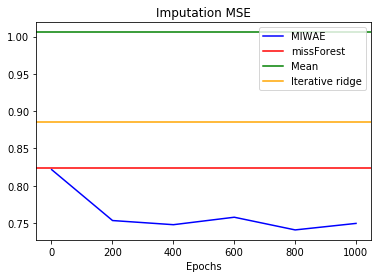

In [71]:
import matplotlib.pyplot as plt
plt.plot(range(1,n_epochs,200),mse_train,color="blue")
plt.axhline(y=mse(xhat_mf,xfull,mask),  linestyle='-',color="red")
plt.axhline(y=mse(xhat_mean,xfull,mask),  linestyle='-',color="green")
plt.axhline(y=mse(xhat_ridge,xfull,mask),  linestyle='-',color="orange")
plt.legend(["MIWAE","missForest","Mean","Iterative ridge"])
plt.title("Imputation MSE")
plt.xlabel("Epochs")
plt.show()